In [53]:
import gurobipy as gp
import numpy as np
import pandas as pd
from scipy import stats

from gurobi_implementation import GurobiSolution
from data_market import Seller, MarketOperator, Market, Buyer

#### In this notebook I test the data market with real distributions for solar generation, extracted from Pecan Street data for Austin

In [54]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

In [55]:
#reading data from csv

probabilities = pd.read_csv('df_probabilities_100.csv')
probabilities = probabilities['0'].to_list()

g_res = pd.read_csv('df_g_res_100.csv')
generation = g_res.drop('Unnamed: 0', axis = 1).loc[0].to_list()

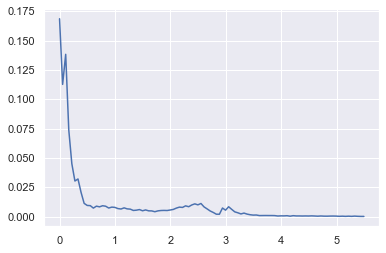

In [56]:
plt.plot(generation, probabilities);

In [57]:
agent_keys = [661, 1642, 2335, 2361, 2818, 3039, 3456, 3538, 4031, 4373, 4767, 5746, 6139, 7536, 7719, 7800, 7901, 7951, 8156, 8386, 8565, 9019, 9160, 9922, 9278]

dataframe_dict = dict()
for key in agent_keys:
    dataframe_dict.update({key : pd.read_csv('/Users/ishilov/Documents/risk_paper/risk_paper/data/df_{}.csv'.format(key))})

community_size = len(dataframe_dict)

for key in agent_keys:
    cond_min = (dataframe_dict[key]['demand'].quantile(0.01) <= dataframe_dict[key]['demand'])
    cond_max = (dataframe_dict[key]['demand'] <= dataframe_dict[key]['demand'].quantile(0.99))
    dataframe_dict[key] = dataframe_dict[key][cond_min & cond_max]

In [58]:
def distribution_build(sample_size, agent_keys):
    res = {}
    
    for key in agent_keys:
        probas_demand, values_demand = np.histogram(dataframe_dict[key]['demand'], bins = sample_size, density=True)
        probas_demand = probas_demand / probas_demand.sum()
        distribution_demand = stats.rv_histogram([probas_demand, values_demand])

        if 'solar' in dataframe_dict[key].columns:
            data = dataframe_dict[key][dataframe_dict[key]['solar'] >= 0]['solar']
            probas_solar, values_solar = np.histogram(data, bins = sample_size, density=True)
            probas_solar = probas_solar / probas_solar.sum()
            distribution_solar = stats.rv_histogram([probas_solar, values_solar])

        res.update({key : 
                    {'probas_demand' : probas_demand,
                    'values_demand' : values_demand,
                    'probas_solar' : probas_solar,
                    'values_solar' : values_solar,
                    'distribution_demand' : distribution_demand,
                    'distribution_solar' : distribution_solar}})

    return res 

In [59]:
def distribution_build_solar(sample_size, agent_keys):
    res = {}
    for key in agent_keys:
        if 'solar' in dataframe_dict[key].columns:
            data = dataframe_dict[key][dataframe_dict[key]['solar'] >= 0]['solar']
            dist = stats.rv_histogram(np.histogram(data, bins = sample_size, density=True))

        res.update({key : dist})

    return res

In [60]:
distributions = distribution_build(100, agent_keys)

In [61]:
distributions_solar = {key : distributions[key]['distribution_solar'] for key in agent_keys}

In [62]:
distributions_solar_2 = distribution_build_solar(100, agent_keys)

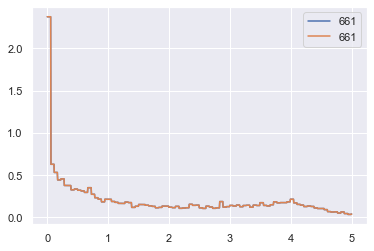

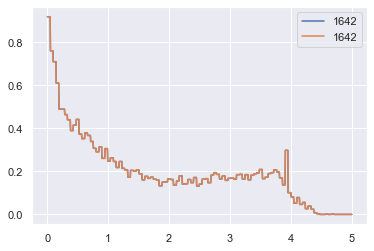

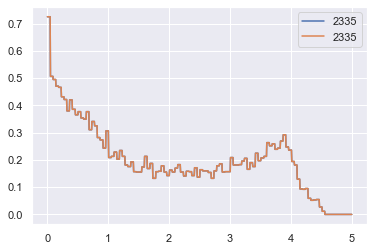

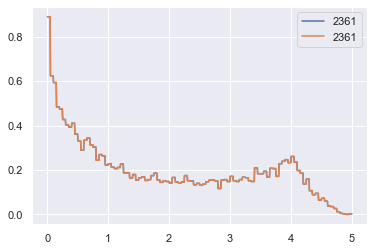

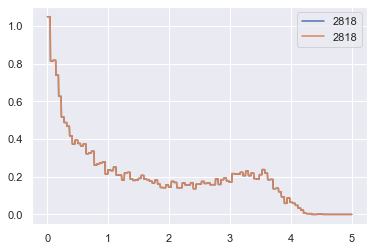

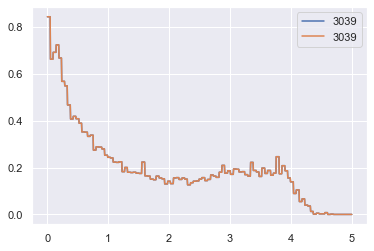

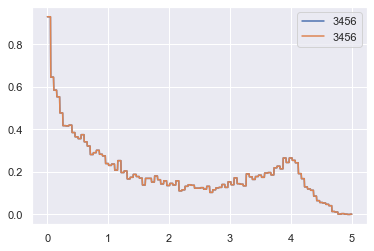

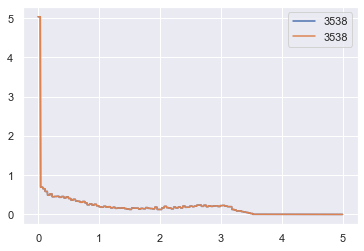

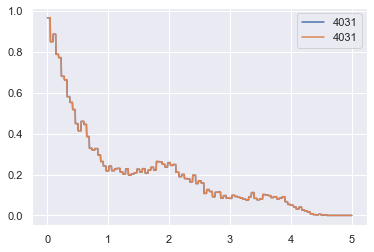

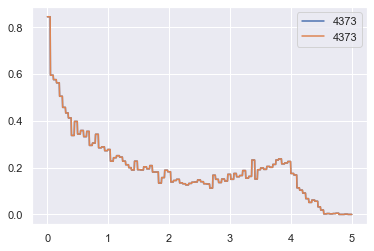

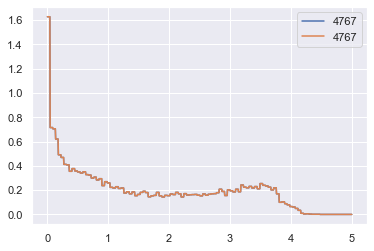

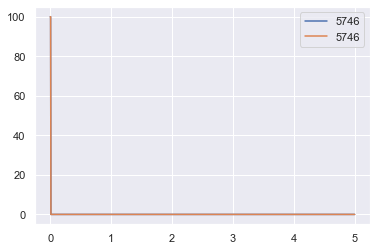

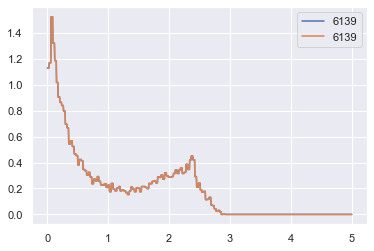

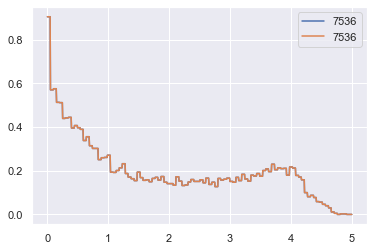

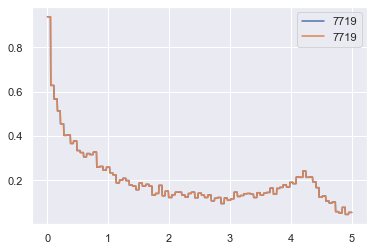

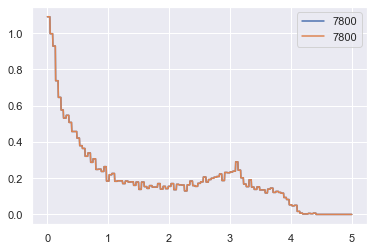

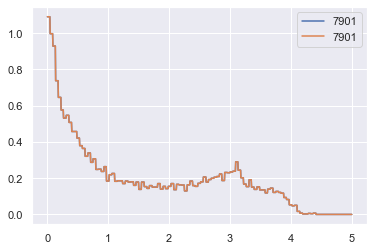

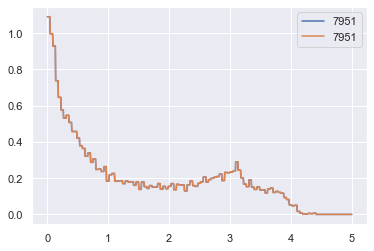

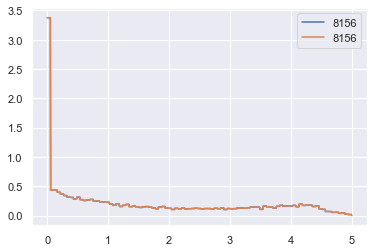

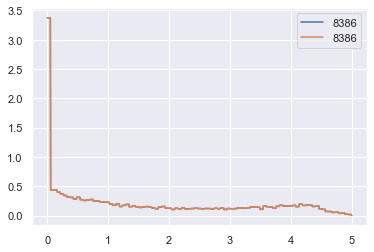

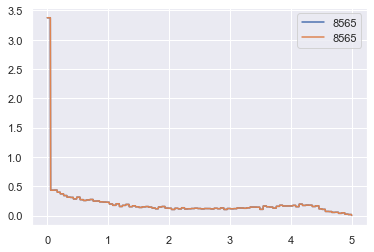

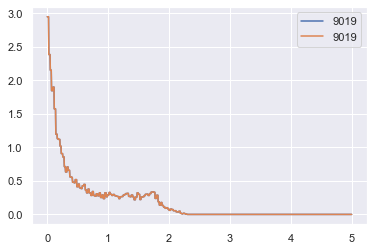

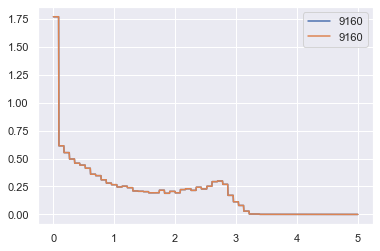

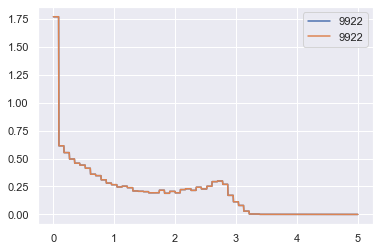

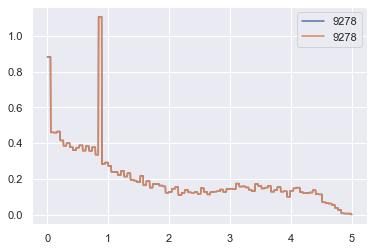

In [63]:
support = np.linspace(0,5, 1000)

for key in agent_keys:
    plt.plot(support, distributions_solar[key].pdf(support), label = key)
    plt.plot(support, distributions_solar_2[key].pdf(support), label = key)
    plt.legend()
    plt.show()

In [64]:
sellers = [Seller(distributions[key]['probas_solar'], distributions[key]['values_solar'], wager = 100) for key in agent_keys[:-2] if key != 5746]
task = 4

In [65]:
buyer = Buyer(distributions[agent_keys[-2]]['probas_solar'], distributions[agent_keys[-2]]['values_solar'], utility = 200)

In [66]:
market_1 = Market(sellers, buyer, task = task)

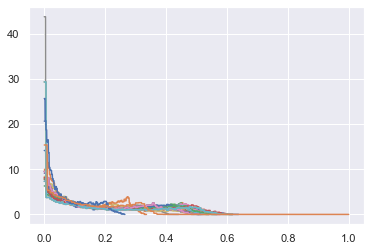

In [67]:
market_1.plot_scaled_forecasts()

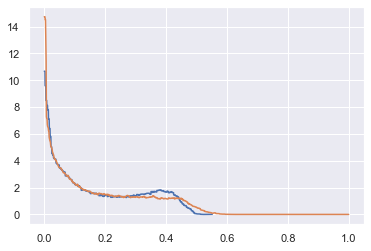

In [68]:
qa_forecast_scaled = market_1.scaled_aggregation(type = 'QA', plot = True)
lop_forecast_scaled = market_1.scaled_aggregation(type = 'LOP', plot = True)

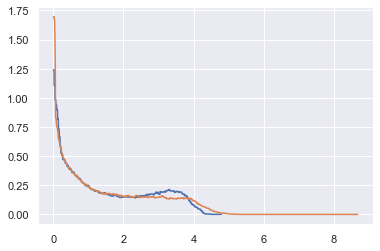

In [69]:
qa_forecast = market_1.aggregation(type = 'QA', plot = True)
lop_forecast = market_1.aggregation(type = 'LOP', plot = True)

In [70]:
market_1.make_scaling()

In [71]:
print(lop_forecast.cdf(task), lop_forecast_scaled.cdf(market_1.scaled_task))

0.9534120773259758 0.9534120773259758


In [72]:
print(qa_forecast.cdf(task), qa_forecast_scaled.cdf(market_1.scaled_task))

0.9853932263789471 0.9853235380616114


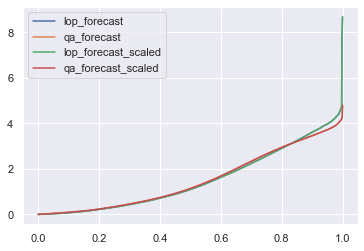

In [73]:
multiplier = max(lop_forecast.support()[-1], qa_forecast.support()[-1])

plt.plot(np.linspace(0,1,1000), lop_forecast.ppf(np.linspace(0,1,1000)), label = 'lop_forecast')
plt.plot(np.linspace(0,1,1000), qa_forecast.ppf(np.linspace(0,1,1000)), label = 'qa_forecast')
plt.plot(np.linspace(0,1,1000), multiplier*lop_forecast_scaled.ppf(np.linspace(0,1,1000)), label = 'lop_forecast_scaled')
plt.plot(np.linspace(0,1,1000), multiplier*qa_forecast_scaled.ppf(np.linspace(0,1,1000)), label = 'qa_forecast_scaled')

plt.legend()

In [74]:
market_1.calculate_payoffs()

[103.81069245 101.02437617 104.30139234 104.97531346 100.00098788
 101.19669826 104.49081442  94.02256998  95.92732197 102.87510266
 100.59829624  91.61774709 103.87635885 105.9667504   99.04273609
  99.04273609  99.04273609 103.20886429 103.20886429 103.20886429
  84.95992955  93.60084716]
[10.83243649 10.45184952 10.8994619  10.99151376 10.31206343 10.47538724
 10.92533533  9.49546269  9.75563552 10.70464293 10.39365065  0.
 10.84140596 11.12693556 10.18117444 10.18117444 10.18117444 10.75023191
 10.75023191 10.75023191  0.          0.        ]


array([ 14.64312894,  11.47622569,  15.20085424,  15.96682721,
        10.31305132,  11.6720855 ,  15.41614975,   3.51803267,
         5.68295748,  13.57974558,  10.99194688,  -8.38225291,
        14.71776481,  17.09368596,   9.22391052,   9.22391052,
         9.22391052,  13.9590962 ,  13.9590962 ,  13.9590962 ,
       -15.04007045,  -6.39915284])

In [75]:
market_1.score_dict

{'Seller #0': 0.7930537978014363,
 'Seller #1': 0.7651906349820066,
 'Seller #2': 0.7979607967016686,
 'Seller #3': 0.8047000078736836,
 'Seller #4': 0.7549567521141423,
 'Seller #5': 0.7669138558704773,
 'Seller #6': 0.7998550174629223,
 'Seller #7': 0.695172573080872,
 'Seller #8': 0.7142200929554314,
 'Seller #9': 0.7836978998748395,
 'Seller #10': 0.7609298356861536,
 'Seller #11': 0.6711243442184555,
 'Seller #12': 0.7937104618144812,
 'Seller #13': 0.814614377324039,
 'Seller #14': 0.7453742341459458,
 'Seller #15': 0.7453742341459458,
 'Seller #16': 0.7453742341459458,
 'Seller #17': 0.7870355161948007,
 'Seller #18': 0.7870355161948007,
 'Seller #19': 0.7870355161948007,
 'Seller #20': 0.604546168831029,
 'Seller #21': 0.6909553448708896}

In [76]:
market_1.buyers_score

0.6909553448708896